In [2]:

!pip install mlflow --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.sklearn
from mlflow import log_metric, log_param, log_artifact

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.inspection import permutation_importance
from sklearn import tree

from pydotplus import graph_from_dot_data
import graphviz
from IPython.display import Image

import itertools

plt.style.use("fivethirtyeight")
pd.plotting.register_matplotlib_converters()


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
!wget -nc "http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
!unzip -o "Bike-Sharing-Dataset.zip"

--2020-09-05 19:36:56--  http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K  1.06MB/s    in 0.3s    

2020-09-05 19:36:56 (1.06 MB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [5]:
bike_sharing = pd.read_csv("hour.csv")
bike_sharing

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [6]:

bike_sharing.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [7]:
bike_sharing.drop(columns=["instant", "dteday", "registered", "casual"], inplace=True)

In [8]:

bike_sharing.rename(
    columns={
        "yr": "year",
        "mnth": "month",
        "hr": "hour_of_day",
        "holiday": "is_holiday",
        "workingday": "is_workingday",
        "weathersit": "weather_situation",
        "temp": "temperature",
        "atemp": "feels_like_temperature",
        "hum": "humidity",
        "cnt": "rented_bikes",
    },
    inplace=True,
)
bike_sharing.head(3)

,season,year,month,hour_of_day,is_holiday,weekday,is_workingday,weather_situation,temperature,feels_like_temperature,humidity,windspeed,rented_bikes
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32


In [9]:
bike_sharing.isnull().any

<bound method DataFrame.any of        season   year  month  ...  humidity  windspeed  rented_bikes
0       False  False  False  ...     False      False         False
1       False  False  False  ...     False      False         False
2       False  False  False  ...     False      False         False
3       False  False  False  ...     False      False         False
4       False  False  False  ...     False      False         False
...       ...    ...    ...  ...       ...        ...           ...
17374   False  False  False  ...     False      False         False
17375   False  False  False  ...     False      False         False
17376   False  False  False  ...     False      False         False
17377   False  False  False  ...     False      False         False
17378   False  False  False  ...     False      False         False

[17379 rows x 13 columns]>

In [10]:
bike_sharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   season                  17379 non-null  int64  
 1   year                    17379 non-null  int64  
 2   month                   17379 non-null  int64  
 3   hour_of_day             17379 non-null  int64  
 4   is_holiday              17379 non-null  int64  
 5   weekday                 17379 non-null  int64  
 6   is_workingday           17379 non-null  int64  
 7   weather_situation       17379 non-null  int64  
 8   temperature             17379 non-null  float64
 9   feels_like_temperature  17379 non-null  float64
 10  humidity                17379 non-null  float64
 11  windspeed               17379 non-null  float64
 12  rented_bikes            17379 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.7 MB


In [11]:
bike_sharing.describe()

,season,year,month,hour_of_day,is_holiday,weekday,is_workingday,weather_situation,temperature,feels_like_temperature,humidity,windspeed,rented_bikes
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


In [12]:
bike_sharing.season.unique()

array([1, 2, 3, 4])

In [19]:
by_season = bike_sharing.groupby(['season'])['rented_bikes'].sum()
by_season.head()

season
1     471348
2     918589
3    1061129
4     841613
Name: rented_bikes, dtype: int64

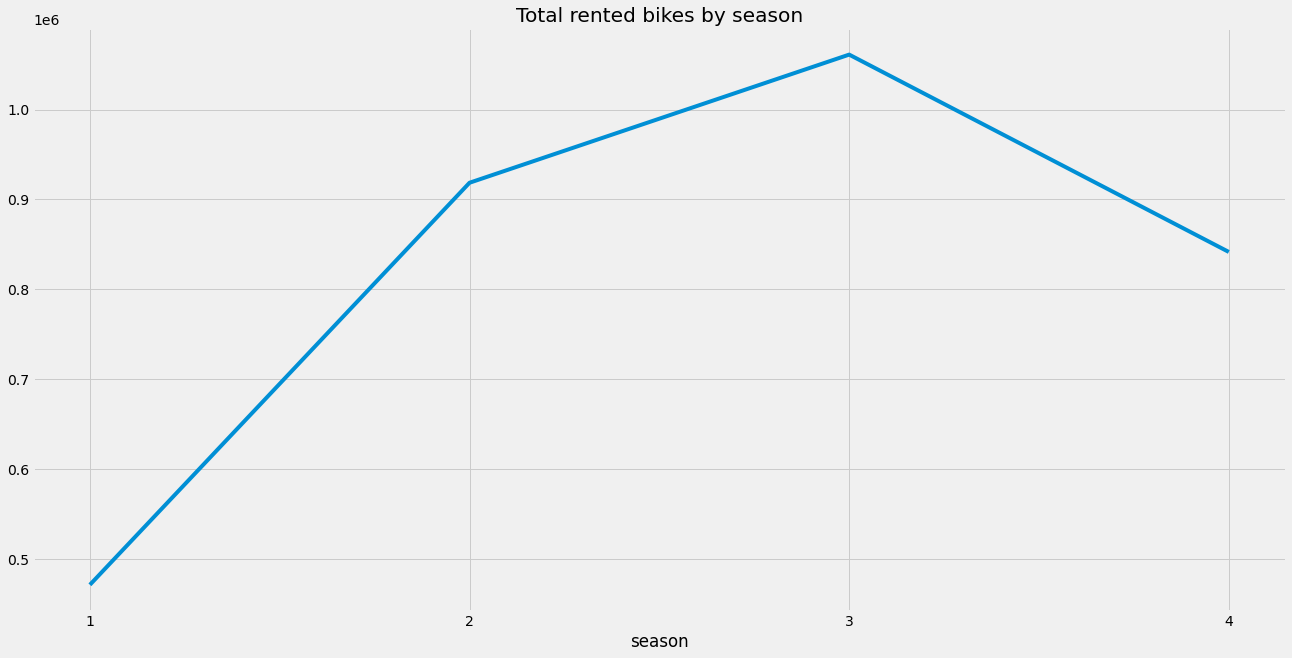

In [20]:
by_season.plot( kind="line", 
    title="Total rented bikes by season",
    xticks=by_season.index,
    figsize=(20, 10),
)

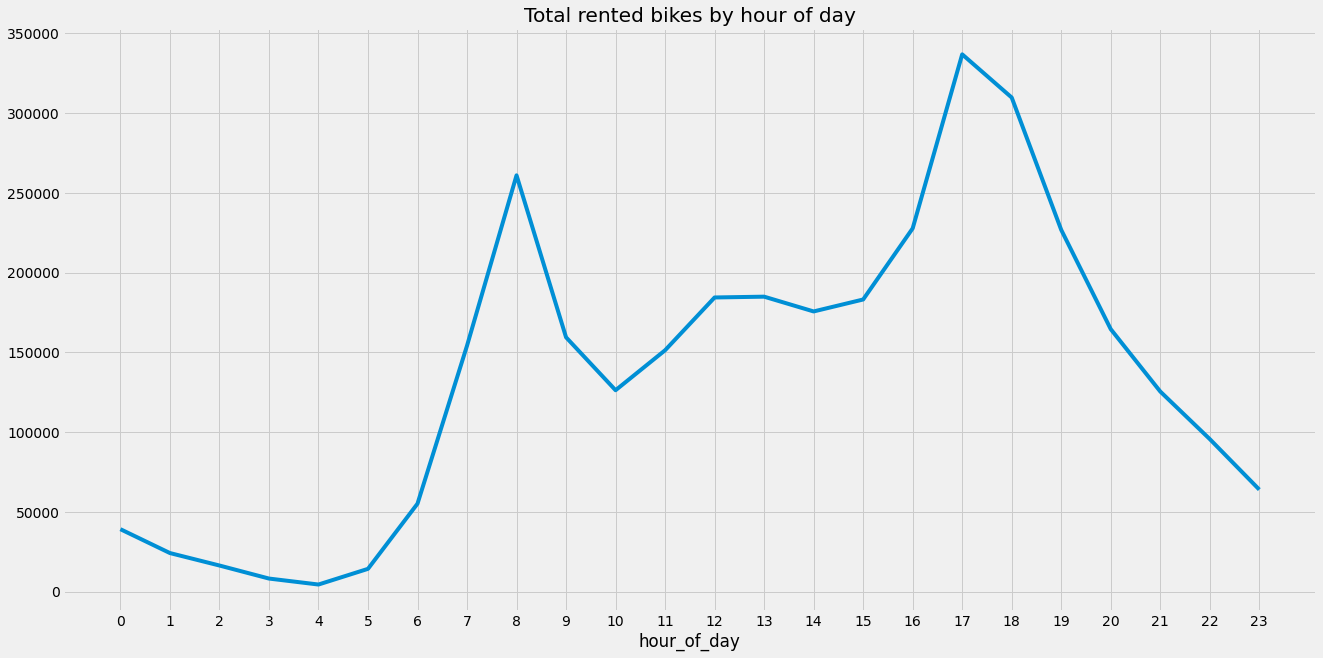

In [21]:
hour = bike_sharing.groupby(['hour_of_day'])['rented_bikes'].sum()
hour.plot(kind ='line', title="Total rented bikes by hour of day",
    xticks=hour.index, figsize=(20, 10))


In [22]:
X = bike_sharing.drop("rented_bikes", axis=1)
y = bike_sharing.rented_bikes
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

print(f"Training samples: {X_train.size}")

Training samples: 145980


In [23]:
experiment_name = "rented_bikes 1"

mlflow.set_experiment(experiment_name)
mlflow.end_run()

INFO: 'rented_bikes 1' does not exist. Creating a new experiment


In [24]:
def rmsle_cv(model, X_train, y_train):
    kf = KFold(n_splits=3, shuffle=True, random_state=42).get_n_splits(X_train.values)
    # Evaluate a score by cross-validation
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse


def rmse_cv_score(model, X_train, y_train):
    score = rmsle_cv(model, X_train, y_train)
    print("Cross-Validation RMSE score: {:.4f} (std = {:.4f})".format(score.mean(), score.std()))
    return score

In [25]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def rmse_score(y, y_pred):
    score = rmse(y, y_pred)
    print("RMSE score: {:.4f}".format(score))
    return score

In [26]:

def log_mlflow_run(model):
    # log model class name
    name = model.__class__.__name__
    mlflow.set_tag("model", name)

    # log input features
    mlflow.set_tag("features", str(X_train.columns.values.tolist()))

    # Log all model parameters
    # mlflow.log_params(model.get_params())

    # Log tracked parameters only
    mlflow.log_params({key: model.get_params()[key] for key in parameters})
    # mlflow.log_param("Training size", X_test.size)
    # mlflow.log_param("Test size", y_test.size)

    mlflow.log_metrics({
        'RMSE_CV': score_cv.mean(),
        'RMSE': score,
    })

    # log training loss
    for s in model.train_score_:
        mlflow.log_metric("Train Loss", s)

    # Save model to artifacts
    mlflow.sklearn.log_model(model, name)

    # log charts
    mlflow.log_artifacts("model_artifacts")

In [27]:
def model_feature_importance(model):
    feature_importance = pd.DataFrame(
        model.feature_importances_,
        index=X_train.columns,
        columns=["Importance"],
    )

    # sort by importance
    feature_importance.sort_values(by="Importance", ascending=False, inplace=True)

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=feature_importance.reset_index(),
        y="index",
        x="Importance",
    ).set_title("Feature Importance")
    # save image
    plt.savefig("model_artifacts/feature_importance.png", bbox_inches='tight')

In [28]:
def model_permutation_importance(model):
    p_importance = permutation_importance(model, X_test, y_test, random_state=42, n_jobs=-1)

    # sort by importance
    sorted_idx = p_importance.importances_mean.argsort()[::-1]
    p_importance = pd.DataFrame(
        data=p_importance.importances[sorted_idx].T,
        columns=X_train.columns[sorted_idx]
    )

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=p_importance,
        orient="h"
    ).set_title("Permutation Importance")

    # save image
    plt.savefig("model_artifacts/permutation_importance.png", bbox_inches="tight")

In [29]:
def model_tree_visualization(model):
    # generate visualization
    tree_dot_data = tree.export_graphviz(
        decision_tree=model.estimators_[0, 0],  # Get the first tree,
        label="all",
        feature_names=X_train.columns,
        filled=True,
        rounded=True,
        proportion=True,
        impurity=False,
        precision=1,
    )

    # save image
    graph_from_dot_data(tree_dot_data).write_png("model_artifacts/Decision_Tree_Visualization.png")

    # show tree
    return graphviz.Source(tree_dot_data)

In [30]:
!mkdir -p "model_artifacts"

In [31]:
get_ipython().system_raw("mlflow ui --port 5000 &")

In [32]:
!pip install pyngrok --quiet
from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
public_url = ngrok.connect(port="5000", proto="http", options={"bind_tls": True})
print("MLflow Tracking UI:", public_url)


MLflow Tracking UI: https://6267395ade03.ngrok.io


In [33]:

parameters = {
    "learning_rate": [0.1, 0.05, 0.01],
    "max_depth": [4, 5, 6],
    # "verbose": True,
}

In [34]:
params_keys = parameters.keys()
params_values = [
    parameters[key] if isinstance(parameters[key], list) else [parameters[key]]
    for key in params_keys
]
runs_parameters = [
    dict(zip(params_keys, combination)) for combination in itertools.product(*params_values)
]

print(params_values)
print(runs_parameters)

[[0.1, 0.05, 0.01], [4, 5, 6]]
[{'learning_rate': 0.1, 'max_depth': 4}, {'learning_rate': 0.1, 'max_depth': 5}, {'learning_rate': 0.1, 'max_depth': 6}, {'learning_rate': 0.05, 'max_depth': 4}, {'learning_rate': 0.05, 'max_depth': 5}, {'learning_rate': 0.05, 'max_depth': 6}, {'learning_rate': 0.01, 'max_depth': 4}, {'learning_rate': 0.01, 'max_depth': 5}, {'learning_rate': 0.01, 'max_depth': 6}]


In [35]:
best_score = float("inf")
best_model = None

model_class = GradientBoostingRegressor

# training loop
for i, run_parameters in enumerate(runs_parameters):
    print(f"Run {i}: {run_parameters}")

    # mlflow: stop active runs if any
    if mlflow.active_run():
        mlflow.end_run()
    # mlflow:track run
    mlflow.start_run()

    # create model instance
    model = model_class(**run_parameters)

    # train
    model.fit(X_train, y_train)

    # get evaluations scores
    score = rmse_score(y_test, model.predict(X_test))
    score_cv = rmse_cv_score(model, X_train, y_train)

    # generate charts
    model_feature_importance(model)
    plt.close()
    model_permutation_importance(model)
    plt.close()
    model_tree_visualization(model)

    # mlflow: log metrics
    log_mlflow_run(model)

    # mlflow: end tracking
    mlflow.end_run()

    # track best model - lower RMSE score is better
    if score_cv.mean() < best_score:
        best_score = score_cv.mean()
        best_model = model

    print("")

Run 0: {'learning_rate': 0.1, 'max_depth': 4}
RMSE score: 52.0011
Cross-Validation RMSE score: 56.5330 (std = 0.1508)

Run 1: {'learning_rate': 0.1, 'max_depth': 5}
RMSE score: 44.6928
Cross-Validation RMSE score: 48.1907 (std = 0.1719)

Run 2: {'learning_rate': 0.1, 'max_depth': 6}
RMSE score: 41.8689
Cross-Validation RMSE score: 44.9779 (std = 0.4127)

Run 3: {'learning_rate': 0.05, 'max_depth': 4}
RMSE score: 63.1489
Cross-Validation RMSE score: 67.8215 (std = 1.7227)

Run 4: {'learning_rate': 0.05, 'max_depth': 5}
RMSE score: 53.0496
Cross-Validation RMSE score: 55.9853 (std = 0.8665)

Run 5: {'learning_rate': 0.05, 'max_depth': 6}
RMSE score: 46.2857
Cross-Validation RMSE score: 49.7954 (std = 0.5325)

Run 6: {'learning_rate': 0.01, 'max_depth': 4}
RMSE score: 120.1656
Cross-Validation RMSE score: 123.9446 (std = 1.0540)

Run 7: {'learning_rate': 0.01, 'max_depth': 5}
RMSE score: 112.4921
Cross-Validation RMSE score: 116.0879 (std = 0.9958)

Run 8: {'learning_rate': 0.01, 'max_dep

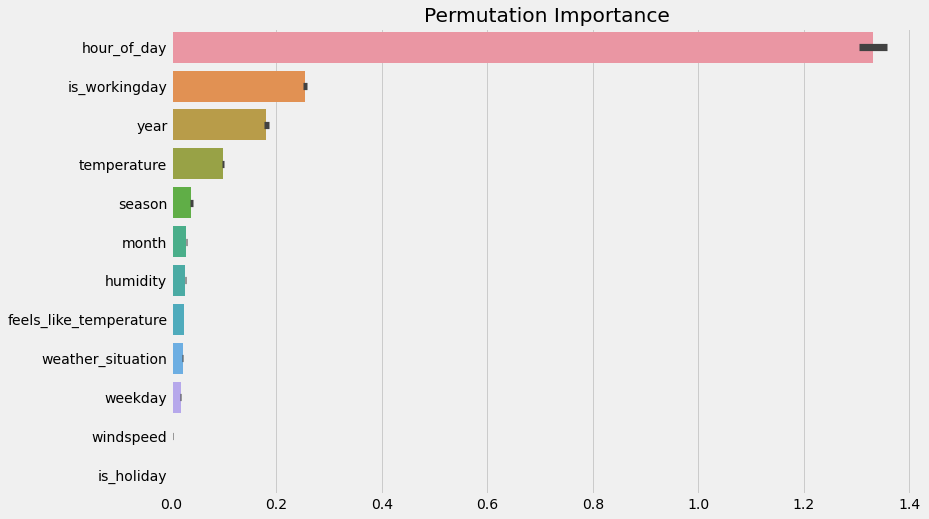

In [36]:
model_permutation_importance(best_model)

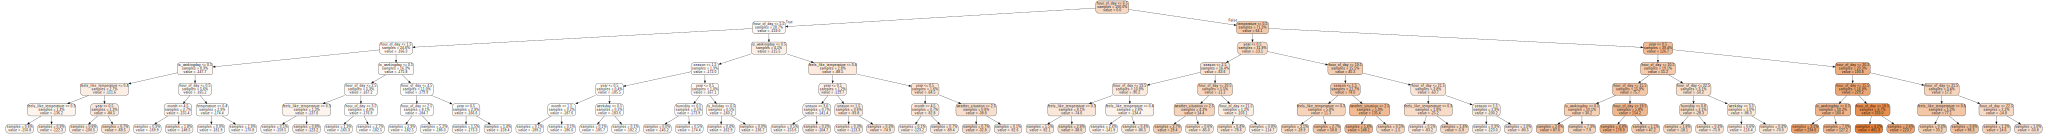

In [37]:
model_tree_visualization(best_model)

**Inference**

In [39]:

test_predictions = X_test.copy()
# real output (rented_bikes) from test dataset
test_predictions["rented_bikes"] =y_test

# add "predicted_rented_bikes" from test dataset
test_predictions["predicted_rented_bikes"] = best_model.predict(X_test)
# show results
test_predictions

,season,year,month,hour_of_day,is_holiday,weekday,is_workingday,weather_situation,temperature,feels_like_temperature,humidity,windspeed,rented_bikes,predicted_rented_bikes
12830,3,1,6,19,0,6,0,1,0.80,0.6970,0.27,0.1940,425,397.751377
8688,1,1,1,20,1,1,0,1,0.24,0.2273,0.41,0.2239,88,99.324280
7091,4,0,10,2,0,5,1,1,0.32,0.3030,0.66,0.2836,4,13.548190
12230,2,1,5,19,0,2,1,1,0.78,0.7121,0.52,0.3582,526,564.780496
431,1,0,1,0,0,4,1,1,0.26,0.2273,0.56,0.3881,13,10.348277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12749,2,1,6,10,0,3,1,1,0.82,0.7727,0.52,0.1343,167,182.581170
11476,2,1,4,9,0,6,0,2,0.38,0.3939,0.37,0.0000,214,241.177947
12847,3,1,6,12,0,0,0,1,0.80,0.6970,0.33,0.2239,556,555.478810
16721,4,1,12,12,0,2,1,1,0.52,0.5000,0.68,0.1940,312,297.368395


**plotting rented bikes vs predicted bikes**

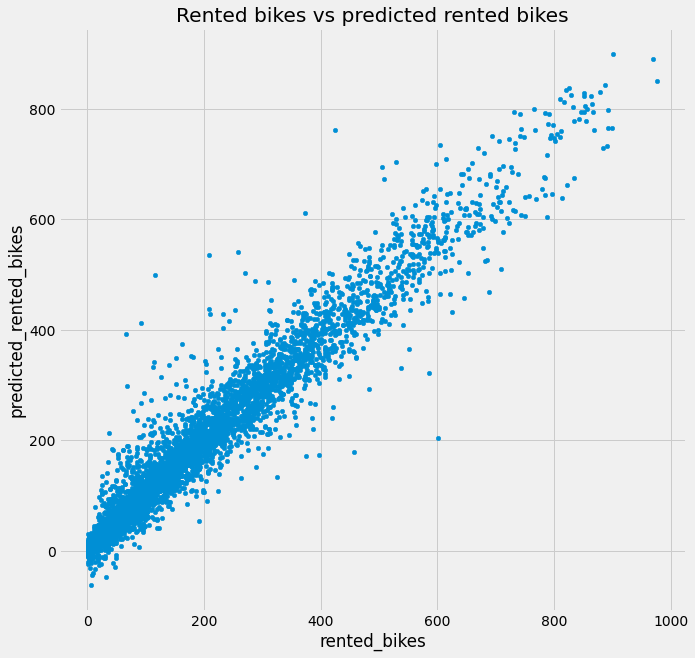

In [43]:
test_predictions.plot.scatter(title="Rented bikes vs predicted rented bikes"
                      ,x="rented_bikes",
    y="predicted_rented_bikes",figsize=(10, 10))